In [74]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt # type: ignore

In [75]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


##### Make classification data:

In [76]:
from sklearn.datasets import make_circles # type: ignore


# Make 1000 samples 
n_samples = 3000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.04, # a little bit of noise to the dots
                    random_state=47) # keep random state so we get the same values

In [77]:
y = y.reshape(-1, 1)

In [78]:
X.shape, y.shape

((3000, 2), (3000, 1))

In [79]:
df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y[:, 0]})
df.head()

,x1,x2,y
0,0.247893,-0.788165,1
1,0.961860,0.325725,0
2,-0.077359,-1.066680,0
3,0.402354,0.763478,1
4,0.045377,0.775663,1


In [80]:
df.y.value_counts()

1    1500
0    1500
Name: y, dtype: int64

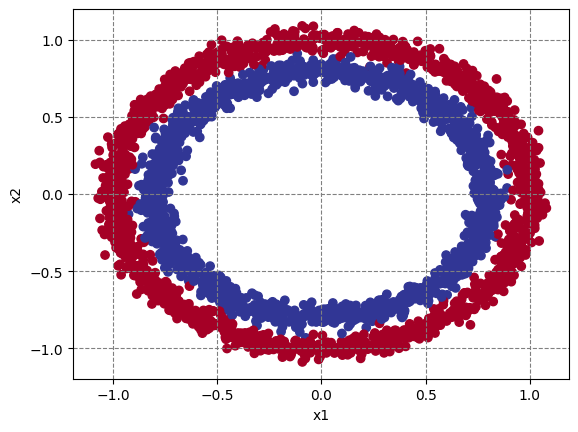

In [81]:
# now, let's plot the data
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

plt.xlabel('x1');
plt.ylabel('x2');

plt.grid(True, linestyle='--', color='gray');

plt.show();

In [82]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [83]:
X.shape, y.shape

(torch.Size([3000, 2]), torch.Size([3000, 1]))

In [84]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train,
                                                    stratify=y,
                                                    random_state=47) # make the random split reproducible

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2400, 2]),
 torch.Size([600, 2]),
 torch.Size([2400, 1]),
 torch.Size([600, 1]))

##### Building model

In [85]:
from torch import nn

In [86]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [87]:
# let's put all data into cuda
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [88]:
# let's build the model

class CircleModelV0(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        Z1 = self.layer_1(x)
        A1 = Z1
        Z2 = self.layer_2(A1)
        A2 = Z2
        return A2

In [89]:
model_0 = CircleModelV0().to(device)

In [90]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [91]:
model_0(X_train)

tensor([[-0.3629],
        [-0.3715],
        [-0.4505],
        ...,
        [-0.3980],
        [-0.3028],
        [-0.2124]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [92]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.0405,  0.0299],
         [ 0.1913,  0.4364],
         [-0.5772,  0.3682],
         [ 0.4018, -0.6857],
         [-0.4690,  0.2893]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.6267, -0.4445, -0.0103, -0.0171, -0.2013], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.4427, -0.2260,  0.0827, -0.0021,  0.0968]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.1795], device='cuda:0', requires_grad=True)]

In [93]:
# let's define the loss fn and the optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

In [94]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [95]:
torch.sigmoid(model_0(X_test[:5]))

tensor([[0.4138],
        [0.4287],
        [0.4268],
        [0.3755],
        [0.3713]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [96]:
torch.round(torch.sigmoid(model_0(X_test[:5])))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [97]:
y_pred = torch.round(torch.sigmoid(model_0(X_test)))

correct = torch.eq(y_test, y_pred).sum().item()
correct

300

In [98]:
acc = correct / y_test.shape[0]
acc

0.5

In [99]:
y_train = torch.squeeze(y_train)
y_test = torch.squeeze(y_test)

y_train.shape, y_test.shape

(torch.Size([2400]), torch.Size([600]))

In [100]:
# let's define the training loop

def training_loop(X_train, y_train, X_test, y_test, loss_fn, optimizer, n_iterations, model):
    
    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    
    # Build training and evaluation loop
    for epoch in range(n_iterations):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
        
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model_0(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
        
                # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
    
    return train_loss_values, test_loss_values

In [101]:
n_iterations = 200

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_0.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_0)

Epoch: 0 | Loss: 0.71295, Accuracy: 50.00% | Test loss: 0.70837, Test acc: 50.00%

Epoch: 10 | Loss: 0.71138, Accuracy: 50.00% | Test loss: 0.70683, Test acc: 50.00%

Epoch: 20 | Loss: 0.70995, Accuracy: 50.00% | Test loss: 0.70543, Test acc: 50.00%

Epoch: 30 | Loss: 0.70865, Accuracy: 50.00% | Test loss: 0.70416, Test acc: 50.00%

Epoch: 40 | Loss: 0.70747, Accuracy: 50.00% | Test loss: 0.70300, Test acc: 50.00%

Epoch: 50 | Loss: 0.70639, Accuracy: 50.00% | Test loss: 0.70195, Test acc: 50.00%

Epoch: 60 | Loss: 0.70541, Accuracy: 50.00% | Test loss: 0.70099, Test acc: 50.00%

Epoch: 70 | Loss: 0.70452, Accuracy: 50.00% | Test loss: 0.70012, Test acc: 50.00%

Epoch: 80 | Loss: 0.70370, Accuracy: 50.00% | Test loss: 0.69932, Test acc: 50.00%

Epoch: 90 | Loss: 0.70296, Accuracy: 50.00% | Test loss: 0.69860, Test acc: 50.00%

Epoch: 100 | Loss: 0.70228, Accuracy: 50.00% | Test loss: 0.69794, Test acc: 50.00%

Epoch: 110 | Loss: 0.70166, Accuracy: 50.00% | Test loss: 0.69735, Test acc:

In [102]:
def plot_loss_curves(epochs, train_loss_values, test_loss_values):
    # Create a figure with size 6x4 inches
    plt.figure(figsize=(6, 4))
    
    # Plot the training and test loss values
    plt.plot(range(epochs), train_loss_values, label="Train loss")
    plt.plot(range(epochs), test_loss_values, label="Test loss")
    
    # Set the title and labels
    plt.title("Training and Test Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    # Add a legend
    plt.legend()
    
    # Add a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

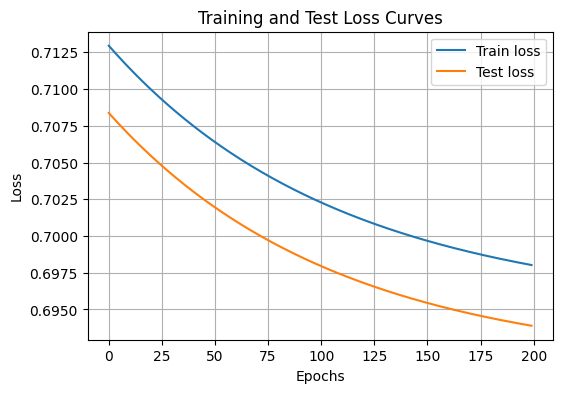

In [103]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [104]:
# let's add non-linearity of the model_0

class CircleModelV1(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        # First layer with tanh activation (non-linearity)
        Z1 = self.layer_1(x)
        A1 = torch.tanh(Z1)
        
        # Second layer (no activation here, since BCEWithLogitsLoss expects raw logits)
        Z2 = self.layer_2(A1)
        
        return Z2

In [105]:
model_1 = CircleModelV1().to(device)

In [106]:
n_iterations = 200

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_1.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_1)

Epoch: 0 | Loss: 0.70614, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 10 | Loss: 0.70520, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 20 | Loss: 0.70435, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 30 | Loss: 0.70356, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 40 | Loss: 0.70283, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 50 | Loss: 0.70215, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 60 | Loss: 0.70153, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 70 | Loss: 0.70096, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 80 | Loss: 0.70043, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 90 | Loss: 0.69994, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 100 | Loss: 0.69949, Accuracy: 49.75% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 110 | Loss: 0.69907, Accuracy: 47.96% | Test loss: 0.69389, Test acc:

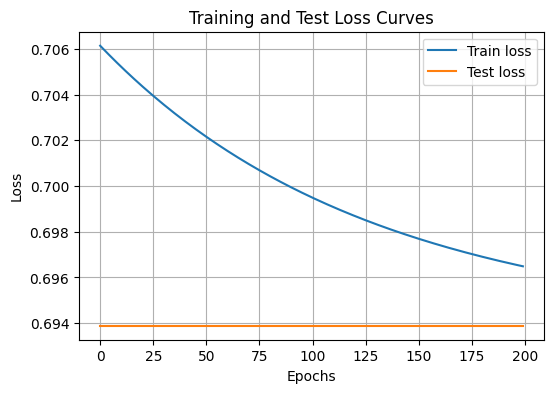

In [107]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [108]:
from helper_functions import plot_predictions, plot_decision_boundary

In [115]:

def plot_train_test_boundaries(model, X_train, y_train, X_test, y_test):
    """
    Plots decision boundaries for both training and test sets.
    
    Args:
        model: The trained model used for prediction.
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
    """
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot decision boundary for the training set
    plt.subplot(1, 2, 1)
    plt.title("Training Set Decision Boundary")
    plot_decision_boundary(model, X_train, y_train)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Plot decision boundary for the test set
    plt.subplot(1, 2, 2)
    plt.title("Test Set Decision Boundary")
    plot_decision_boundary(model, X_test, y_test)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


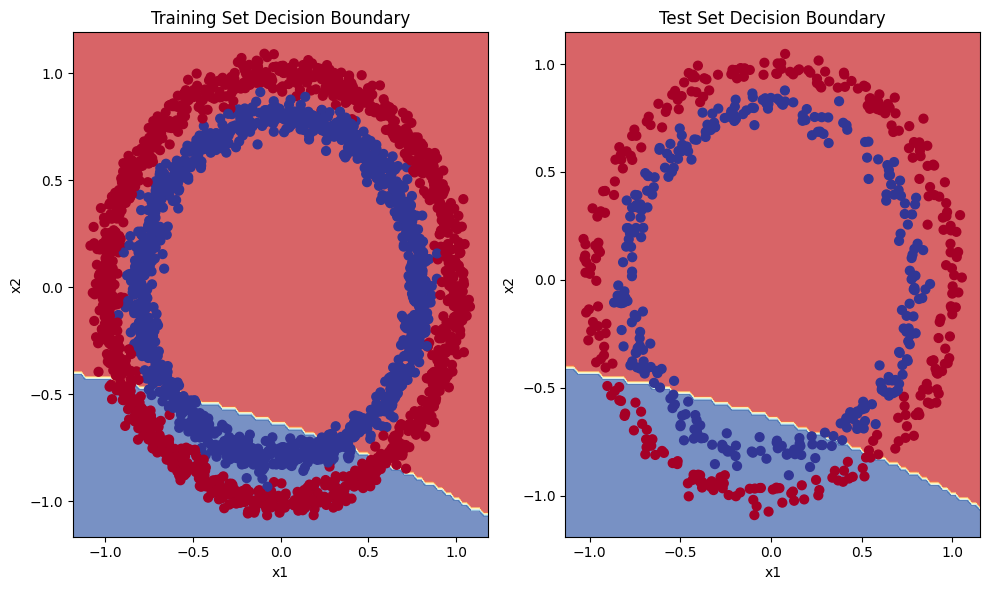

In [116]:
# Example usage
plot_train_test_boundaries(model_1, X_train, y_train, X_test, y_test)

In [123]:
# let's add non-linearity of the model_0

class CircleModelV2(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # First layer with relu activation (non-linearity)
        Z1 = self.layer_1(x)
        A1 = torch.relu(Z1)
        
        # Second layer with relu activation
        Z2 = self.layer_2(A1)
        A2 = torch.relu(Z2)
        
        # third layer (output layer) (no activation here, since BCEWithLogitsLoss expects raw logits) 
        Z3 = self.layer_3(A2)
        
        return Z3

In [124]:
model_2 = CircleModelV2().to(device)
list(model_2.parameters())

[Parameter containing:
 tensor([[-0.0589, -0.2442],
         [ 0.3723, -0.3904],
         [ 0.4639, -0.6147],
         [ 0.6323, -0.1861],
         [ 0.0760,  0.6319],
         [ 0.6322,  0.6040],
         [ 0.3562, -0.0503],
         [ 0.0332,  0.5647],
         [ 0.2800,  0.4781],
         [-0.0414,  0.7050],
         [ 0.0772,  0.1120],
         [-0.3458, -0.5131],
         [-0.3279, -0.5416],
         [ 0.1924, -0.3218],
         [ 0.3615,  0.6324],
         [ 0.4064,  0.5682]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.6546, -0.1185,  0.5539, -0.5658, -0.3618, -0.4797,  0.6461, -0.6478,
         -0.0233,  0.3237,  0.1818, -0.3860, -0.6408,  0.0995,  0.0300,  0.6601],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0685, -0.0762,  0.1905, -0.2062,  0.0362,  0.2309,  0.0410, -0.1168,
          -0.0853,  0.2361, -0.1624,  0.0172, -0.1261, -0.1250,  0.1998,  0.1157],
         [-0.1498, -0.0555,  0.2199, -0.0466, -0.0357,

In [125]:
n_iterations = 200

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_2.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_2)

Epoch: 0 | Loss: 0.69372, Accuracy: 44.96% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 10 | Loss: 0.69369, Accuracy: 44.67% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 20 | Loss: 0.69367, Accuracy: 44.46% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 30 | Loss: 0.69364, Accuracy: 43.96% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 40 | Loss: 0.69361, Accuracy: 43.58% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 50 | Loss: 0.69359, Accuracy: 42.88% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 60 | Loss: 0.69356, Accuracy: 42.58% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 70 | Loss: 0.69354, Accuracy: 42.29% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 80 | Loss: 0.69351, Accuracy: 42.17% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 90 | Loss: 0.69349, Accuracy: 42.21% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 100 | Loss: 0.69346, Accuracy: 41.92% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 110 | Loss: 0.69344, Accuracy: 41.92% | Test loss: 0.69389, Test acc:

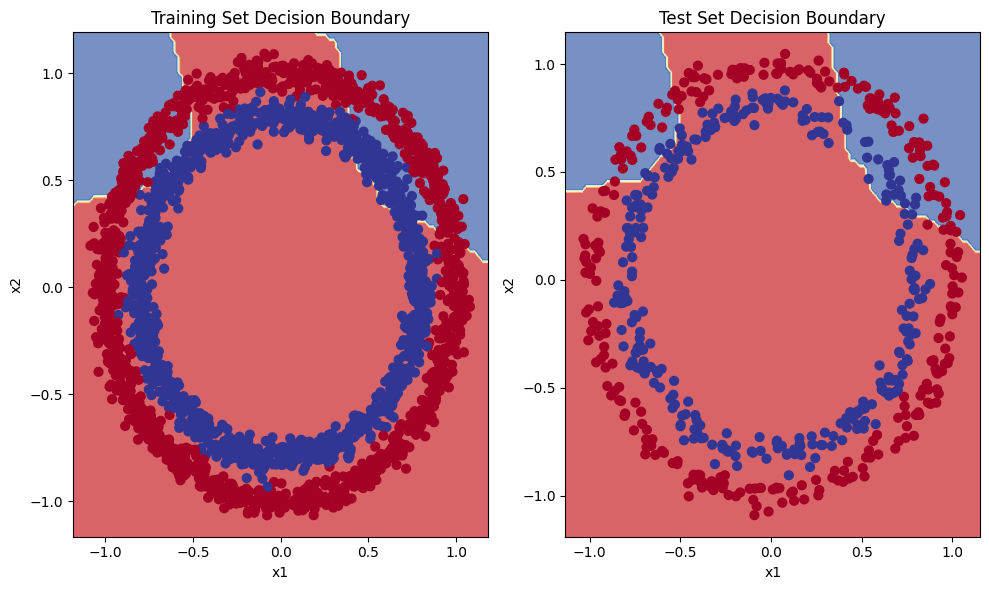

In [126]:
# Example usage
plot_train_test_boundaries(model_2, X_train, y_train, X_test, y_test)

In [133]:

class CircleModelV3(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        # Define a deeper architecture with more neurons
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        #self.layer_4 = nn.Linear(in_features=16, out_features=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Pass through each layer with ReLU activations
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        # x = self.relu(self.layer_3(x))
        
        # Final layer (logits, no activation as BCEWithLogitsLoss expects raw logits)
        x = self.layer_3(x)
        return x

In [146]:
model_3 = CircleModelV3().to(device)
list(model_3.parameters())

[Parameter containing:
 tensor([[-6.5975e-01, -1.2062e-01],
         [-3.1321e-01,  2.3103e-01],
         [ 2.4107e-01,  5.7132e-01],
         [ 1.1039e-01,  1.5104e-04],
         [-1.0619e-01, -4.1232e-01],
         [ 2.5561e-01,  1.2183e-01],
         [ 2.2452e-01,  5.2774e-01],
         [-1.9570e-01,  2.6841e-01],
         [ 3.8545e-01,  2.8141e-01],
         [-2.9776e-01,  2.2293e-01]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.5967,  0.1776,  0.0880, -0.7036,  0.6616, -0.3081,  0.0200,  0.0561,
         -0.3934, -0.5873], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 5.1595e-02,  1.5107e-01,  2.7020e-01,  1.8243e-01,  2.8106e-01,
          -4.6422e-02,  2.4134e-01, -3.6617e-02,  1.1964e-01,  1.4713e-02],
         [-2.4477e-01, -2.9104e-01,  2.0956e-01,  1.0735e-01, -2.8757e-01,
          -9.4577e-02, -2.7681e-01, -3.0676e-01, -9.9572e-02,  1.0348e-01],
         [ 2.2668e-01, -1.3011e-01, -6.2570e-03,  1.7145e-01, -2.5086e-01

In [147]:
n_iterations = 1000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.Adam(
                                    params=model_3.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_3)

Epoch: 0 | Loss: 0.70553, Accuracy: 50.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 10 | Loss: 0.60149, Accuracy: 67.38% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 20 | Loss: 0.28947, Accuracy: 91.04% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 30 | Loss: 0.09073, Accuracy: 97.92% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 40 | Loss: 0.04481, Accuracy: 98.88% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 50 | Loss: 0.03251, Accuracy: 99.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 60 | Loss: 0.02813, Accuracy: 98.88% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 70 | Loss: 0.02620, Accuracy: 99.08% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 80 | Loss: 0.02543, Accuracy: 99.12% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 90 | Loss: 0.02478, Accuracy: 99.17% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 100 | Loss: 0.02400, Accuracy: 99.00% | Test loss: 0.69389, Test acc: 49.83%

Epoch: 110 | Loss: 0.02291, Accuracy: 99.04% | Test loss: 0.69389, Test acc:

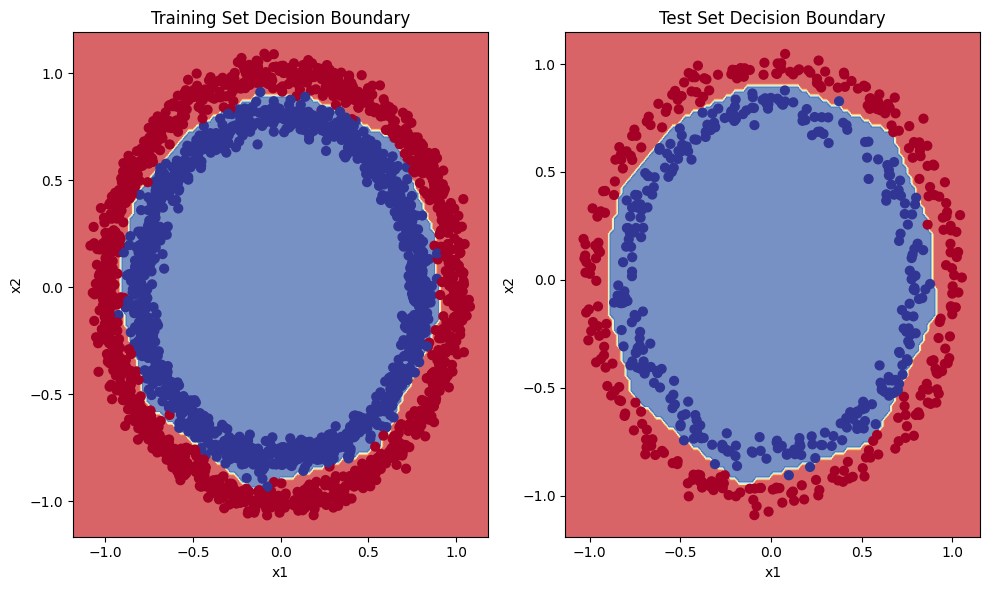

In [148]:
# Example usage
plot_train_test_boundaries(model_3, X_train, y_train, X_test, y_test)

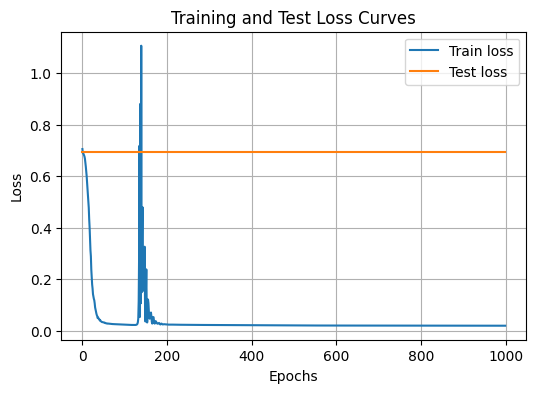

In [149]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)